In [1]:
# imports
import os
import sys
from PIL import Image

import rasterio
import pandas as pd
import matplotlib.pyplot as plt

from rasterio.warp import reproject, Resampling, calculate_default_transform
import numpy as np
from rasterio.enums import Resampling
from skimage.morphology import erosion, dilation, diamond, square, opening, disk
from scipy import ndimage
from datetime import datetime
from skimage.filters import threshold_local

import skimage
from skimage.segmentation import clear_border,watershed
from skimage.feature import peak_local_max
import cv2
import imageio


from ebfloeseg.peakdet import peakdet
from ebfloeseg.utils import getmeta, getres, imshow, write_mask_values
from ebfloeseg.masking import create_rgb_masked, maskrgb, create_cloud_mask, create_land_mask, mask_image
from ebfloeseg.savefigs import imsave

In [2]:
# meta
# this is the same landmask as the original IFT- can be downloaded w SOIT
outfile='reproj_land.tiff'
s=rasterio.open(outfile)
land_mask= create_land_mask(outfile)

# ## load files
data_direc='input/'
save_direc='output/'
ftci_direc=data_direc+'tci/'
#ffci_direc=data_direc+'fci/'
fcloud_direc=data_direc+'cloud/'

#option to save figs after each step
save_figs=True
year=2012

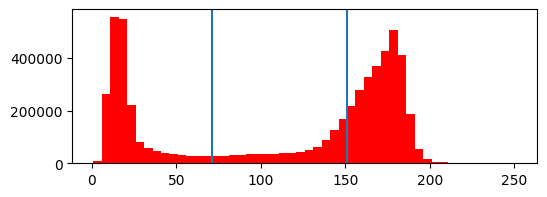

In [12]:
# main loop


for i in np.arange(
    214, 215, 1
):  # 94,274range of julian days where there is light in the Beaufort Sea
    doy = i
    aq = False  # aqua or terra
    if aq:
        sat = "aqua"
    else:
        sat = "terra"

    doy_str = str(doy)  # TODO: use getmeta
    year_str = str(year)  # TODO: use getmeta
    res = datetime.strptime(year_str + "-" + doy_str, "%Y-%j").strftime(
        "%Y-%m-%d"
    )  # TODO use getres(fcloud)

    fcloud = f"{fcloud_direc}cloud_{res}_{doy}_{sat}.tiff"  # TODO read from files
    ftci = f"{ftci_direc}tci_{res}_{doy}_{sat}.tiff"

    # open all files
    cloud = rasterio.open(fcloud)
    tci = rasterio.open(ftci)

    # this pulls in the cloud mask file where red indicates >95% cloud cover
    # so that is what I am masking out here
    # but I think could just change to reading in false color and doing a...
    # simple cloud mask from the first (NIR) channel as in original IFT

    cloud_mask = create_cloud_mask(fcloud)

    red_c, green_c, blue_c = tci.read()

    rgb = np.dstack([red_c, green_c, blue_c])

    maskrgb(rgb, cloud_mask)
    if save_figs:
        # save cloud mask on RGB
        imsave(tci, rgb, save_direc, doy, "cloud_mask_on_rgb.tif")

    maskrgb(rgb, land_mask)
    if save_figs:
        imsave(tci, rgb, save_direc, doy, "land_cloud_mask_on_rgb.tif")

    ## adaptive threshold for ice mask
    thresh_adaptive = threshold_local(red_c, block_size=399)
    image = red_masked = rgb[:, :, 0]

    # here just determining the min and max values for the adaptive threshold
    binz = np.arange(1, 256, 5)
    rn, rbins = np.histogram(red_masked.flatten(), bins=binz)
    dx = 0.01 * np.mean(rn)
    rmaxtab, rmintab = peakdet(rn, dx, x=None)
    rmax_n = rbins[rmaxtab[-1, 0]]
    rm1_n = rbins[rmaxtab[0, 0]]
    rhm_high = rmaxtab[-1, 1] / 2
    rhm_low = rmaxtab[0, 1] / 4

    ow_cut_min = 100 if ~np.any(rmintab) else rbins[rmintab[-1, 0]]

    ow_cut_max_cond = np.where(
        (rbins[:-1] < rmax_n) & (rn <= rhm_high)
    )  # TODO: add comment
    if np.any(ow_cut_max_cond):
        ow_cut_max = rbins[ow_cut_max_cond[0][-1]]  # fwhm to left of ice max
    else:
        ow_cut_max = rmax_n - 10

    if save_figs:
        fig, ax = plt.subplots(1, 1, figsize=(6, 2))
        plt.hist(red_masked.flatten(), bins=binz, color="r")
        plt.axvline(ow_cut_max)
        plt.axvline(ow_cut_min)
        plt.savefig(save_direc + "ice_mask_hist.png")

    # mask thresh_adaptive
    mask_image(thresh_adaptive, thresh_adaptive < ow_cut_min, ow_cut_min)
    mask_image(thresh_adaptive, thresh_adaptive > ow_cut_max, ow_cut_max)

    ice_mask = image > thresh_adaptive
    lmd = land_mask + cloud_mask
    write_mask_values(land_mask, lmd, ice_mask, doy, year, save_direc)

    # saving ice mask
    if save_figs:
        # imsave(tci, ice_mask, save_direc, doy, "test_ice_mask_bw.tif", count=1, rollaxis=False, as_uint8=True) Not working
        with rasterio.Env():
            profile = tci.profile
            profile.update(dtype=rasterio.uint8, count=1, compress="lzw")

            with rasterio.open(
                save_direc + str(doy) + "ice_mask_bw.tif", "w", **profile
            ) as dst:
                dst.write(ice_mask.astype(rasterio.uint8), 1)

    # here dialating the land and cloud mask so any floes that are adjacent to the mask can be removed later
    kernel = diamond(10)  # np.ones((3,3), np.uint8)
    lmd = skimage.morphology.binary_dilation(lmd.astype(int), kernel)

    # setting up different kernel for erosion-expansion algo
    kernel_er1 = diamond(1)
    kernel_er2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))

    inp = ice_mask
    input_no = ice_mask
    r = 0
    output = np.zeros((np.shape(ice_mask)))
    inpuint8 = inp.astype(np.uint8)
    for it in np.arange(8, 2, -1):
        # erode a lot at first, decrease number of iterations each time
        im3 = cv2.erode(inpuint8, kernel_er1, iterations=it)
        im3 = ndimage.binary_fill_holes(im3.astype(np.uint8)).astype(np.uint8)

        im2 = cv2.dilate(inpuint8, kernel_er1, iterations=it).astype(np.uint8)

        # label floes remaining after erosion
        ret, markers = cv2.connectedComponents(im3)

        # Add one to all labels so that sure background is not 0, but 1
        markers = markers + 1

        unknown = cv2.subtract(im2, im3)

        # Now, mark the region of unknown with zero
        mask_image(markers, unknown == 255, 0)

        # dilate each marker
        for a in np.arange(0, it + 1, 1):
            markers = skimage.morphology.dilation(markers, kernel_er1)

        # rewatershed
        im4 = cv2.watershed(rgb, markers)

        # get rid of floes that intersect the dilated land mask
        im4[np.isin(im4, np.unique(im4[(lmd) & (im4 > 1)]))] = 1

        # set the open water and already identified floes to no
        im4[~input_no] = 1

        # get rid of ones that are too small
        area_lim = (it) ** 4
        props = skimage.measure.regionprops_table(im4, properties=["label", "area"])
        df = pd.DataFrame.from_dict(props)
        im4[np.isin(im4, df[df.area < area_lim].label.values)] = 1

        if save_figs:
            with rasterio.Env():
                # Write an array as a raster band to a new 8-bit file. For
                # the new file's profile, we start with the profile of the source
                profile = tci.profile

                # And then change the band count to 1, set the
                # dtype to uint8, and specify LZW compression.
                profile.update(dtype=rasterio.uint8, count=1, compress="lzw")

                with rasterio.open(
                    save_direc
                    + str(doy)
                    + "identification_round_"
                    + str(r)
                    + "_not_sharp8_m1_nows.tif",
                    "w",
                    **profile,
                ) as dst:
                    dst.write(im4.astype(rasterio.uint8), 1)

        r += 1  # r is just for tracking the iteration round for naming figures

        inp = (im4 == 1) & (inp == 1) & ice_mask
        im4[im4 < 2] = 0
        output = im4 + output

    # saving the props table
    output = opening(output)
    props = skimage.measure.regionprops_table(
        output.astype(int),
        red_c,
        properties=[
            "label",
            "area",
            "centroid",
            "axis_major_length",
            "axis_minor_length",
            "orientation",
            "perimeter",
            "intensity_mean",
        ],
    )
    df = pd.DataFrame.from_dict(props)
    df.to_csv(save_direc + res + "_" + str(doy) + "_" + sat + ".csv")

    # saving the label floes tif
    with rasterio.Env():
        profile = tci.profile
        profile.update(dtype=rasterio.uint8, count=1, compress="lzw")
        with rasterio.open(
            save_direc + res + "_" + str(doy) + "_" + sat + "_final.tif", "w", **profile
        ) as dst:
            dst.write(output.astype(rasterio.uint8), 1)

In [ ]:
getmeta(fcloud)

('214', '2012', 'terra')